In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
torch.cuda.empty_cache()
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
# images_path = Path('./data/images')
# anno_path = Path('./')

In [3]:
# def filelist(root, file_type):
#     """Функция возвращает полностью квалифицированный список файлов в директории"""
#     return [os.path.join(directory_path, f) for directory_path, directory_name, 
#             files in os.walk(root) for f in files if f.endswith(file_type)]

# def generate_train_df (anno_path):
#     annotations = filelist(anno_path, '.xml')
#     anno_list = []
#     for anno_path in annotations:
#         root = ET.parse(anno_path).getroot()
#         anno = {}
#         anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
#         anno['width'] = root.find("./size/width").text
#         anno['height'] = root.find("./size/height").text
#         anno['class'] = root.find("./object/name").text
#         anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
#         anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
#         anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
#         anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
#         anno_list.append(anno)
#     return pd.DataFrame(anno_list)

In [4]:
df_train = pd.read_csv("./data/train_labels_.csv")
df_train.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [5]:
class_dict = {'raccoon': 0}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [6]:
df_train.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,0,95,60,167,118
1,raccoon-11.jpg,660,432,0,3,1,461,431
2,raccoon-63.jpg,600,400,0,74,107,280,290
3,raccoon-63.jpg,600,400,0,227,93,403,298
4,raccoon-60.jpg,273,185,0,58,33,197,127


### resize image

In [7]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [8]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [9]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
#     im_resized = cv2.resize(im, (int(1.49*sz), sz))
#     Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    im_resized = cv2.resize(im, (int(1*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [10]:
new_paths = []
new_bbs = []
train_path_resized = Path('./data/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(Path('./data/' + row['filename']), train_path_resized, create_bb_array(row.values), 128)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [11]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,raccoon-17.jpg,259,194,0,95,60,167,118,data\images_resized\raccoon-17.jpg,"[39.0, 47.0, 77.0, 82.0]"
1,raccoon-11.jpg,660,432,0,3,1,461,431,data\images_resized\raccoon-11.jpg,"[0.0, 0.0, 127.0, 89.0]"
2,raccoon-63.jpg,600,400,0,74,107,280,290,data\images_resized\raccoon-63.jpg,"[34.0, 16.0, 92.0, 59.0]"
3,raccoon-63.jpg,600,400,0,227,93,403,298,data\images_resized\raccoon-63.jpg,"[30.0, 48.0, 95.0, 85.0]"
4,raccoon-60.jpg,273,185,0,58,33,197,127,data\images_resized\raccoon-60.jpg,"[22.0, 27.0, 87.0, 92.0]"


#### original img

In [12]:
im = cv2.imread('./data/'+ str(df_train.values[1][0]))
bb = create_bb_array(df_train.values[1])
print(im.shape)

(432, 660, 3)


In [13]:
Y = create_mask(bb, im)
mask_to_bb(Y)

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


array([  1.,   3., 430., 460.], dtype=float32)

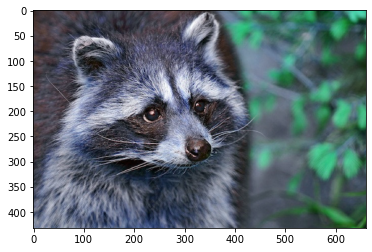

In [14]:
plt.imshow(im)

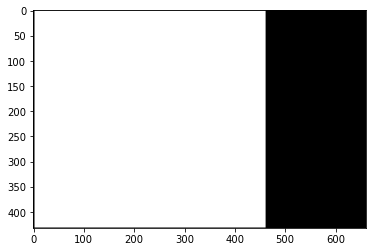

In [15]:
plt.imshow(Y, cmap='gray')

#### resized img

In [16]:
im = cv2.imread(str(df_train.values[1][8]))
bb = df_train.values[1][9]
print(im.shape)

(128, 128, 3)


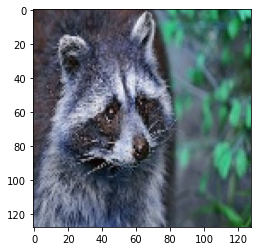

In [17]:
plt.imshow(im)

In [18]:
Y = create_mask(bb, im)
mask_to_bb(Y)

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


array([  0.,   0., 126.,  88.], dtype=float32)

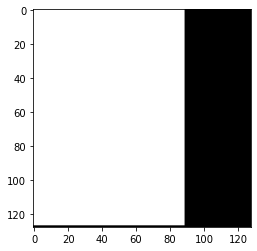

In [19]:
plt.imshow(Y, cmap='gray')

In [20]:
# train_path_resized

In [21]:
# im = read_image(Path('./data/' + str(df_train.values[1][0])))

In [22]:
# im_resized = cv2.resize(im, (int(1.49*300), 300))

In [23]:
# Y_resized = cv2.resize(create_mask(create_bb_array(df_train.values[1]), im), (int(1.49*300), 300))

In [24]:
# new_path = str(train_path_resized/Path('./data/' + str(df_train.values[1][0])).parts[-1])
# new_path

In [25]:
# cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))

### augmentation

In [26]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [27]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [28]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

data\images_resized\raccoon-79.jpg


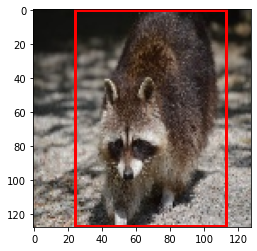

In [29]:
number = 15
im = cv2.imread(str(df_train.values[number][8]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


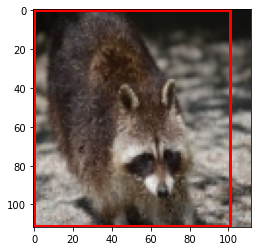

In [30]:
im, bb = transformsXY(str(df_train.values[number][8]),df_train.values[number][9],True )
show_corner_bb(im, bb)

### dataset

In [31]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [32]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [33]:
class RacoonsDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [34]:
train_ds = RacoonsDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RacoonsDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [35]:
batch_size = 4
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [36]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### model

In [37]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [38]:
model = BB_model().to(device)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 15

In [39]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.to(device).float()
        y_class = y_class.to(device)
        y_bb = y_bb.to(device).float()
#         print(x.shape)
#         print(y_bb.shape)
#         print(y_class.shape)
        optimizer.zero_grad()
    
        out_class, out_bb = model(x)
#         print(out_bb.shape)
#         print(out_class.shape)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        loss = loss_class + loss_bb/C

        loss.backward()
        optimizer.step()
        
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.to(device).float()
        y_class = y_class.to(device)
        y_bb = y_bb.to(device).float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


train_loss 1.015 val_loss 0.727 val_acc 1.000
train_loss 0.100 val_loss 0.094 val_acc 1.000
train_loss 0.049 val_loss 0.062 val_acc 1.000
train_loss 0.048 val_loss 0.073 val_acc 1.000
train_loss 0.048 val_loss 0.093 val_acc 1.000
train_loss 0.047 val_loss 0.111 val_acc 1.000
train_loss 0.048 val_loss 0.090 val_acc 1.000
train_loss 0.049 val_loss 0.125 val_acc 1.000
train_loss 0.047 val_loss 0.081 val_acc 1.000
train_loss 0.048 val_loss 0.082 val_acc 1.000
train_loss 0.047 val_loss 0.571 val_acc 1.000
train_loss 0.046 val_loss 0.158 val_acc 1.000
train_loss 0.047 val_loss 0.205 val_acc 1.000
train_loss 0.049 val_loss 0.092 val_acc 1.000
train_loss 0.047 val_loss 0.063 val_acc 1.000


### test

In [40]:
im = read_image('./data/raccoon-89.jpg')
im = cv2.resize(im, (int(1*128), 128))

In [41]:
# test Dataset
test_ds = RacoonsDataset(pd.DataFrame([{'path':'./data/raccoon-89.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [42]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 178, 237])

In [43]:
# prediction
out_class, out_bb = model(xx.to(device))
out_class, out_bb

(tensor([[ 7.6329, -3.2264, -2.8390, -2.8264]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[  3.9265,   5.9625, 111.0071, 104.1438]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [44]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([7.6329], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

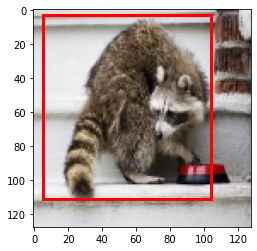

In [45]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [46]:
resnet = models.resnet34(pretrained=True)
layers = list(resnet.children())[:8]
print(layers)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [57]:
fcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
layers = list(fcnn.children())[1:]
print(layers)

[BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): 